# Successive Convexification for Nonlinear Model Predictive Control with Continuous-Time Constraint Satisfaction

## Libraries

In [1]:
import numpy as np
import cvxpy as cp

import typing as T
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import os
import glob
from PIL import Image
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
from cycler import cycler
# mpl.rcParams['axes.prop_cycle'] = cycler(color='rkgbcmy')
mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.fontsize': 11})
mpl.rcParams.update({'axes.xmargin': 0})
mpl.rcParams.update({'lines.solid_capstyle': 'round'})
mpl.rcParams.update({'lines.solid_joinstyle': 'round'})
mpl.rcParams.update({'lines.dash_capstyle': 'round'})
mpl.rcParams.update({'lines.dash_joinstyle': 'round'})
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
save_animation = False
save_fig = False
fig_format = ['pdf', 'png'][0]

## Parameters

In [3]:
def params_fcn() -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """
    
    def ref_pos_fcn(t : float) -> np.ndarray:
        A = 5.0
        damping = 0.05

        x = -10. + 20 * t / 30
        w = 0.3 + 1.25*t/30
        y = A * np.exp(-damping*t) * np.sin(np.pi/2 + w * (x+10))
        return np.array([x, y])

    total_time = 30.0
    N = 17
    Ns = 4
    t_h = 8.0 # [s] Prediction horizon for the Model Predictive Contol
    t_scp = t_h/(N-1)
    t_mpc = t_h/Ns

    n_states = 6 # p_x, p_y, v_x, v_y, obs_ctcs, ref_ctcs
    n_controls = 2 # a_x, a_y

    x_init  = np.array([-10., 0., 0., 0., 0., 0.])

    X_last = np.zeros((n_states, N))
    U_last = np.zeros((n_controls, N))

    return dict(
        # ---------------------------------------------------------------------------------------------------

        # General Parameters
        total_time = total_time,  # Total simulation time [s]
        N = N,
        Ns = Ns,
        t_h = t_h, # [s] Prediction horizon for the Model Predictive Contol
        t_scp = t_scp, # [s]
        t_mpc = t_mpc, # [s]
        dt = 0.025,  # [s]

        n_states = n_states, # p_x, p_y, v_x, v_y, obs_ctcs, ref_ctcs
        n_controls = n_controls, # Acceleration along x and y directions
        inp_param = 'FOH',

        x_init = x_init,

        X_last = X_last,
        U_last = U_last,

        vehicle_v_max = 2.5, # [m/s]
        vehicle_a_max = 5.0, # [m/s^2]
        cd = 0.05, # Drag coefficient

        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 3, # Total number of iterations for the prox_linear algorithm
        w_obj = 1, # Penalization weight for the actual cost
        w_con = 1e3, # Penalization weight for the constraint
        
        # Prox-linear via adaptive step-size
        adaptive_step = False, # Updates the step-size of prox-linear
        w_ptr = 0.03, # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.001, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.9, # Minimum linearization accuracy to decrease the w_ptr
        

        # ---------------------------------------------------------------------------------------------------

        # Obstacles
        obs_node = False, # For node-only
        obs_ctcs = True, # For CTCS
        w_obs_ctcs = 10,
        obs_sensor_range = 6., # [m]
        H_obs = [
                 np.array([[ 2.4 , 0.],
                           [ 0.  , 0.4]]),
                 np.array([[ 2.4 , 0.],
                           [ 0.  , 0.4]]),
                 np.array([[ 2.4 , 0.],
                           [ 0.  , 0.4]]),
                 np.array([[ 2.4 , 0.],
                           [ 0.  , 0.4]]),
                 np.array([[ 2.4 , 0.],
                           [ 0.  , 0.4]]),
                ],
        p_obs = [
                 np.array([-6.5, -3.0]),
                 np.array([-1.8,  3.5]),
                 np.array([ 0.5, -3.5]),
                 np.array([ 2.7,  1.5]),
                 np.array([ 6.2, -3.0]),
                ],
        r_obs = 1,
        obs_sfty_fac = 1.05,
        
        # Referance output
        ref_node = False, # For node-only
        ref_ctcs = True, # For CTCS
        w_ref_ctcs = 0.38,
        ref_pos = ref_pos_fcn, # for a time-varying referance output
        
        # ---------------------------------------------------------------------------------------------------
        
        # Integration
        rk4_steps_dyn = 2,
        rk4_steps_J = 5,
    )

## Objective and Constraint Functions

In [4]:
def f_obs(xk : np.ndarray,
          dx : np.ndarray,
          params : T.Dict[str, T.Any],
          npy : bool,
          only_grad : str='Def',
          ) -> T.Tuple[T.Any]:
    """
    Returns the function of obstacle constraint and its gradient
    For node-only case
    """

    p_obs = params['p_obs']
    H_obs = params['H_obs']
    r_obs = params['obs_sfty_fac']
    obs_sensor_range = params['obs_sensor_range']

    N = xk.shape[1]
    
    f_0_max_sq = np.zeros((N))
    grad_max_sq = np.zeros((2, N))
    for idx in range(len(p_obs)):
        p_err = (params['x_init'][0:2] - p_obs[idx])
        p_H_err_norm = np.linalg.norm((H_obs[idx] @ p_err), axis=0)
        
        if p_H_err_norm <= obs_sensor_range:
            err = (xk[0:2, :] - p_obs[idx][:, np.newaxis])
            H_err_norm = np.linalg.norm((H_obs[idx] @ err), axis=0)

            obs_f_pre_max = np.maximum(0, r_obs - H_err_norm)
            f_0_max_sq += obs_f_pre_max**2

            if not(only_grad == 'only_f'):
                HTH = (H_obs[idx]).T @ H_obs[idx]
                grad_max_sq +=  -2 * (HTH @ err) * obs_f_pre_max / H_err_norm

    if only_grad == 'only_g': 
        return grad_max_sq
    elif only_grad == 'only_f': 
        return f_0_max_sq
    else:
        if not(npy):
            gx = cp.multiply(grad_max_sq, (dx[:2, :]))
            l_k = f_0_max_sq + cp.sum(gx, axis=0)

        else:
            gx = np.multiply(grad_max_sq, (dx[:2, :]))
            l_k = f_0_max_sq + np.sum(gx, axis=0)
        
        return f_0_max_sq, l_k

## Vehcile Dynamics

In [5]:
def augmented_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    def f(x,u,p):
        f_obs_max_sq = 0
        if params['obs_ctcs']:
            dx = np.zeros_like(x[:, np.newaxis])
            f_obs_max_sq = f_obs(x[:, np.newaxis], dx, params, npy=True, only_grad='only_f')
            f_obs_max_sq = params['w_obs_ctcs'] * f_obs_max_sq[0]
        
        f_ref = 0
        if params['ref_ctcs']:
            f_ref = params['w_ref_ctcs'] * ((x[0] - p[2])**2 + (x[1] - p[3])**2)
        
        speed = (x[2]**2+x[3]**2)**(0.5)
        return np.array([x[2], 
                         x[3], 
                         u[0] - params['cd'] * x[2] * speed, 
                         u[1] - params['cd'] * x[3] * speed,
                         f_obs_max_sq,
                         f_ref,
                        ])

    def A(x,u,p):
        obs_grad = np.zeros(2)
        if params['obs_ctcs']:
            dx = np.zeros_like(x[:, np.newaxis])
            grad = f_obs(x[:, np.newaxis], dx, params, npy=True, only_grad='only_g')
            obs_grad = params['w_obs_ctcs'] * grad[:,0]
    
        ref_grad = np.zeros(2)
        if params['ref_ctcs']:
            ref_grad = params['w_ref_ctcs'] * (2*(x[0:2] - p[2:4]))
        
        speed = (x[2]**2+x[3]**2 + 1e-6)**(0.5)
        return np.array([[0, 0, 1, 0, 0, 0],
                         [0, 0, 0, 1, 0, 0],
                         [0, 0, -params['cd'] * (speed + x[2]**2 / speed), -params['cd'] * (      x[2]*x[3] / speed), 0, 0],
                         [0, 0, -params['cd'] * (      x[2]*x[3] / speed), -params['cd'] * (speed + x[3]**2 / speed), 0, 0],
                         [obs_grad[0], obs_grad[1], 0, 0, 0, 0],
                         [ref_grad[0], ref_grad[1], 0, 0, 0, 0]])
        
        
    def B(x,u,p):
        return np.array([[0, 0], 
                         [0, 0],
                         [1, 0], 
                         [0, 1], 
                         [0, 0],
                         [0, 0]])

    params['f_func'] = f
    params['A_func'] = A
    params['B_func'] = B

    return params

## Integration

In [6]:
def rk4(func : T.Any,
        y0 : np.ndarray, 
        tf : float, 
        steps : int, 
        *args : T.Tuple[T.Any]) -> np.ndarray:
    """
    Implementation of the fourth-order Runge-Kutta (RK4) method for numerical integration.

    Parameters:
    - f: Function representing the system of ordinary differential equations (ODEs).
    - y0: Initial conditions (numpy array, n-dimensional column vector).
    - t: Time points for which the solution is calculated.

    Returns:
    - y: Solution of the ODEs at each time point.
    """

    t = np.linspace(0, tf, int(steps))  # Time points

    # Ensure y0 is a NumPy array (n-dimensional column vector)
    # y0 = np.array(y0).reshape(-1, 1)
    y0 = y0.reshape(-1, 1)

    # Initialize solution array
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0.flatten()

    # Perform RK4 integration
    for i in range(len(t) - 1):

        h = t[i + 1] - t[i]
        k1 = h * func(y[i], t[i], args)
        k2 = h * func(y[i] + 0.5 * k1, t[i] + 0.5 * h, args)
        k3 = h * func(y[i] + 0.5 * k2, t[i] + 0.5 * h, args)
        k4 = h * func(y[i] + k3, t[i] + h, args)

        y[i + 1, :] = y[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return y

In [7]:
def dxdt(x : np.ndarray,
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:

    """
    return: x_dot(t)
    """

    tt, tf, u_0 , u_1, params = args[0]
    
    p = np.zeros(4)
    p[2:4] = params['ref_pos'](params['t_curr']+tt+t)
    if params['inp_param'] == 'FOH':
        u = u_0 + (t / tf) * (u_1 - u_0)
    elif params['inp_param'] == 'ZOH':
        u = u_0.copy()
        
    return params['f_func'](x, u, p)

def integrate_dynamics(x : np.ndarray,
                       u_0 : np.ndarray,
                       u_1 : np.ndarray,
                       params : T.Dict[str, T.Any],
                       tf : float,
                       tt : float,
                      ) -> T.Tuple[np.ndarray]:
    """
    Integration of the vehicle dynamics [0, tf]
    return: x[t+dt] and u
    """
    x_next = rk4(dxdt, x, tf, params['rk4_steps_dyn'], tt, tf, u_0, u_1, params)[-1,:]
    return x_next

def integrate_multiple(X, U, params):
    
    x_k1_list = []
    for k in range(X.shape[1] - 1):
        tt = k * params['t_scp']
        x_k1 = integrate_dynamics(X[:, k], U[:, k], U[:, k+1], params, params['t_scp'], tt)
        x_k1_list.append(x_k1)
        
    return (np.vstack(x_k1_list)).T

## Discretization

In [8]:
def dVdt(V : np.ndarray, 
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:
    """
    ODE function to compute dVdt.
    V: Evaluation state V = [x, Phi_A, B_bar, C_bar, z_bar]
    t: Evaluation time
    u: Input at start of interval
    return: Derivative at current time and state dVdt
    """

    args = args[0]
    u_0, u_1, tt, params = args

    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    
    x = V[i0:i1]
    p = np.zeros(4)
    if params['ref_ctcs']: p[2:4] = params['ref_pos'](params['t_curr']+tt+t)

    if params['inp_param'] == 'ZOH':
        beta = 0.
    elif params['inp_param'] == 'FOH':
        beta = t / params['t_scp']
    alpha = 1 - beta
    
    u = u_0 + beta * (u_1 - u_0)

    A_subs = params['A_func'](x, u, p)
    B_subs = params['B_func'](x, u, p)
    f_subs = params['f_func'](x, u, p)
    
    z_t = np.squeeze(f_subs) - np.matmul(A_subs, x) - np.matmul(B_subs, u)
    
    dVdt = np.zeros_like(V)
    dVdt[i0:i1] = f_subs.T
    dVdt[i1:i2] = np.matmul(A_subs, V[i1:i2].reshape((n_x, n_x))).reshape(-1)
    dVdt[i2:i3] = (np.matmul(A_subs, V[i2:i3].reshape((n_x, n_u))) + B_subs * alpha).reshape(-1)
    dVdt[i3:i4] = (np.matmul(A_subs, V[i3:i4].reshape((n_x, n_u))) + B_subs * beta).reshape(-1)
    dVdt[i4:i5] = (np.matmul(A_subs, V[i4:i5]).reshape(-1) + z_t)

    return dVdt

def calculate_discretization(X : np.ndarray, 
                             U : np.ndarray, 
                             params : T.Dict[str, T.Any],
                            ) -> T.Dict[str, T.Any]:
    """
    Calculate discretization for given states, inputs and total time.
    X: Matrix of states for all time points
    U: Matrix of inputs for all time points
    return: The discretization matrices
    """
    
    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    
    V0 = np.zeros(i5)
    V0[i1:i2] = np.eye(n_x).reshape(-1)

    f_bar = np.zeros((n_x, params['N']-1))
    A_bar = np.zeros((n_x * n_x, params['N']-1))
    B_bar = np.zeros((n_x * n_u, params['N']-1))
    C_bar = np.zeros((n_x * n_u, params['N']-1))
    z_bar = np.zeros((n_x, params['N']-1))

    for k in range(params['N'] - 1):
        V0[i0:i1] = X[:, k]

        tt = k*params['t_scp']
        V = rk4(dVdt, V0, params['t_scp'], params['rk4_steps_J'], U[:, k], U[:, k+1], tt, params)[-1,:]

        # flatten matrices in column-major (Fortran) order for cvxpy
        f_bar[:, k] = V[i0:i1]
        Phi = V[i1:i2].reshape((n_x, n_x))
        A_bar[:, k] = Phi.flatten(order='F')
        B_bar[:, k] = (V[i2:i3].reshape((n_x, n_u))).flatten(order='F')
        C_bar[:, k] = (V[i3:i4].reshape((n_x, n_u))).flatten(order='F')
        z_bar[:, k] = (V[i4:i5])

    params['f_bar'] = f_bar
    params['A_bar'] = A_bar
    params['B_bar'] = B_bar
    params['C_bar'] = C_bar
    params['z_bar'] = z_bar
    
    return params

## Warm-Start for NMPC

In [9]:
def NMPC_warm_start(x_next : np.ndarray,
                    params : T.Dict[str, T.Any],
                   ) -> T.Dict[str, T.Any]:
    """
    Warm-start for MPC
    MPC: Estimate Referance output and Objective's positions for the given prediction horizon and the step-size
    """
    
    # ---------------------------------------------------------------------------------------------------
    
    # Update the initial state
    params['x_init'] = np.zeros(params['n_states'])
    params['x_init'][0:4] = x_next[0:4].copy()
    
    # ---------------------------------------------------------------------------------------------------
    
    times = np.arange(params['t_curr'], params['t_curr']+params['t_h']+params['t_scp'], params['t_scp'])[: ,np.newaxis]
    params['Ref_out'] = params['ref_pos'](times)[:,:,0]

    # First initialization
    if params['t_curr'] == 0:
        params['X_last'][0, :] = params['Ref_out'][0,:] # Estimation

    # Warm-start for NMPC
    else:
        params['X_last'][:,0:-params['Ns']] = params['X_new'][:, params['Ns']:]
        params['U_last'][:,0:-params['Ns']] = params['U_new'][:, params['Ns']:]
        
        if params['U_last'].shape[1] > 1:
            for idd in range(params['Ns']):
                next_node = integrate_dynamics(params['X_last'][:, -params['Ns']-1+idd], 
                                               params['U_new'][:, -1], 
                                               params['U_new'][:, -1], 
                                               params, 
                                               params['t_scp'], 
                                               tt=0)

                params['X_last'][:2, -params['Ns']+idd] = next_node[:2]
                params['U_last'][:, -1-idd] = params['U_new'][:, -1]

    return params


## Linear / Nonlinear Cost

In [10]:
def scp_non_linear_cost(X_new : np.ndarray,
                        U_new : np.ndarray,
                        X_last : np.ndarray,
                        U_last : np.ndarray,
                        nu_new : np.ndarray,
                        nl_nu_new : np.ndarray,
                        w_tr : float,
                        params : T.Dict[str, T.Any],
                       ) -> T.Tuple[np.ndarray]:
    """
    Returns the nonlinear or linearized cost value of the SCP problem
    Required for prox-linear with adaptive step-size
    """


    cost_dict = dict()

    cost_dict['ptr_cost'] = w_tr * (np.linalg.norm(X_new -  X_last, axis=0)**2 + np.linalg.norm(U_new -  U_last, axis=0)**2).sum()

    cost_dict['lin_cost'] = cost_dict['ptr_cost']
    cost_dict['n_lin_cost'] = cost_dict['ptr_cost']

    if params['obs_ctcs'] or params['ref_ctcs']: # No-need otherwise because dynamics are linear
        cost_dict['lin_dyn_cost'] = params['w_con'] * np.linalg.norm(nu_new.reshape(-1), 1)
        cost_dict['n_lin_dyn_cost'] = params['w_con'] * np.linalg.norm(nl_nu_new.reshape(-1), 1)

        cost_dict['lin_cost'] += cost_dict['lin_dyn_cost']
        cost_dict['n_lin_cost'] += cost_dict['n_lin_dyn_cost']
                
    if params['ref_ctcs']:
        cost_dict['distance_cost'] = params['w_obj'] * (np.linalg.norm(X_new[-1, -1]))

    if params['ref_node']:
        cost_dict['distance_cost'] = params['w_obj'] * (np.linalg.norm(X_new[:2, :] - params['Ref_out'], axis=0).sum())

    cost_dict['lin_cost'] += cost_dict['distance_cost']
    cost_dict['n_lin_cost'] += cost_dict['distance_cost']

    if params['obs_node']:
        _, lin_obs_cost = f_obs(X_last, X_new-X_last, params, npy=True)
        n_lin_obs_cost, _ = f_obs(X_new, X_new-X_new, params, npy=True)

        cost_dict['lin_obs_cost'] = params['w_con'] * np.sum(np.maximum(0, lin_obs_cost))
        cost_dict['n_lin_obs_cost'] = params['w_con'] * np.sum(np.maximum(0, n_lin_obs_cost))

        cost_dict['lin_cost'] += cost_dict['lin_obs_cost']
        cost_dict['n_lin_cost'] += cost_dict['n_lin_obs_cost']
        
    return cost_dict

## Convex Problem (sub-problem)

In [11]:
def solve_convex_problem(X_last : np.ndarray,
                         U_last : np.ndarray,
                         w_tr : float,
                         params : T.Dict[str, T.Any],
                        ) -> T.Tuple[np.ndarray]:
       
    """
    Solves the convex sub-problem using ECOS or MOSEK and retruns the optimal values of X and U
    """
    
    X  = cp.Variable((params['n_states'],   params['N']))
    U  = cp.Variable((params['n_controls'], params['N']))
    nu = cp.Variable((params['n_states'],   params['N']-1))

    cost = 0
    constraints = []

    cost += params['w_con'] * cp.sum(cp.abs(nu))

    if params['ref_ctcs']:
        cost += params['w_obj'] * cp.abs(X[-1, -1])  # CTCS - Target tracking
        constraints += [X[-1, 1:] >= X[-1, 0:-1]] # CTCS - Target tracking

    if params['obs_ctcs']:
        constraints += [cp.abs(X[-2, 1:] - X[-2, 0:-1]) <= 1e-4] # CTCS - Obstacle Avoidance

    if params['ref_node']:
        cost += params['w_obj'] * cp.sum(cp.norm(X[:2, :] - params['Ref_out'], axis=0))  # Node-only Target tracking

    if params['obs_node']:
        _, lin_obs_cost = f_obs(X_last, X-X_last, params, npy=False)
        cost += params['w_con'] * cp.sum(cp.maximum(0, lin_obs_cost))

    cost += w_tr * (cp.sum(cp.norm(X - X_last, axis=0)**2) + cp.sum(cp.norm(U - U_last, axis=0)**2)) # Trust region

    constraints += [X[:, 0] == params['x_init']]
    constraints += [cp.norm(U[:, :], axis=0) <= params['vehicle_a_max']]
    
    constraints += [
        X[:, k + 1] ==
        cp.reshape(params['A_bar'][:, k], (params['n_states'], params['n_states'])) @ X[:, k]
        + cp.reshape(params['B_bar'][:, k], (params['n_states'], params['n_controls'])) @ U[:, k]
        + cp.reshape(params['C_bar'][:, k], (params['n_states'], params['n_controls'])) @ U[:, k+1]
        + params['z_bar'][:, k]
        + nu[:, k]
        for k in range(params['N'] - 1)
    ]

    # Create the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)

    # Solve the optimization problem
    try:
        problem.solve(solver='ECOS')
    except:
        problem.solve(solver='MOSEK')
    
    return X.value, U.value, nu.value

## Prox-linear

In [12]:
def prox_linear(params : T.Dict[str, T.Any],
               ) -> T.Dict[str, T.Any]:

    """
    Solves the non-convex trajectory optimization problem using Penalized Trust Region method (PTR)
    """
        
    X_last = params['X_last']
    U_last = params['U_last']
    w_tr = params['w_ptr']
    last_cost = None
    
    prox_results = dict()
    prox_results['ptr_cost_list'] = []
    prox_results['non_lin_cost_list'] = []
    prox_results['obstacle_cost_list'] = []
    prox_results['tracking_slack_list'] = []

    for i in range(params['ite']):
        params = calculate_discretization(X_last, U_last, params)
        while True:
            if w_tr > 1e8: break
            
            X_new, U_new, nu_new = solve_convex_problem(X_last, U_last, w_tr, params)

            X_nl = X_new.copy()
            if (params['obs_ctcs']) or (params['ref_ctcs']):
                X_nl[:, 1:] = integrate_multiple(X_new, U_new, params)

            cost_dict = scp_non_linear_cost(X_new, U_new,  X_last, U_last, nu_new, (X_new - X_nl),  w_tr, params)
                
            if not(last_cost) or not(params['adaptive_step']):
                X_last = X_new.copy()
                U_last = U_new.copy()
                last_cost = cost_dict['n_lin_cost']
                
                prox_results['ptr_cost_list'].append(cost_dict['ptr_cost'])
                prox_results['non_lin_cost_list'].append(cost_dict['n_lin_cost'])
                prox_results['obstacle_cost_list'].append(np.linalg.norm((X_new - X_nl)[-2, :], 1))
                prox_results['tracking_slack_list'].append(np.linalg.norm((X_new - X_nl)[-1, :], 1))
                break

            else:
                delta_J = last_cost - cost_dict['n_lin_cost']
                delta_L = last_cost - cost_dict['lin_cost']

                rho = delta_J / delta_L
                if rho <= params['r0']:
                    w_tr = w_tr * 2

                else:
                    X_last = X_new.copy()
                    U_last = U_new.copy()
                    last_cost = cost_dict['n_lin_cost']
                    
                    prox_results['ptr_cost_list'].append(cost_dict['ptr_cost'])
                    prox_results['non_lin_cost_list'].append(cost_dict['n_lin_cost'])
                    prox_results['obstacle_cost_list'].append(np.linalg.norm((X_new - X_nl)[-2, :], 1))
                    prox_results['tracking_slack_list'].append(np.linalg.norm((X_new - X_nl)[-1, :], 1))

                    if params['r2'] <= rho:
                        w_tr = np.maximum(w_tr / 2, params['w_ptr_min'])
                    break
    
    params['X_new'] = X_last
    params['U_new'] = U_last

    return prox_results, params

## RUN

In [13]:
def RUN(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    x_all = [params['x_init'][0:4]]
    u_all = []
    x_nmpc_all = []
    u_nmpc_all = []
    ptr_cost_list_all = []
    non_lin_cost_list_all = []
    obstacle_cost_list_all = []
    tracking_slack_list_all = []

    x_next = params['x_init'].copy()
    times = np.arange(0, params['total_time']+params['dt'], params['dt'])
    for i_int in tqdm(range(len(times)-1)):
        params['t_curr'] = times[i_int]

        t_mpc = params['t_curr'] % (params['t_mpc'])
        if t_mpc < (params['dt']-1e-8):

            params = NMPC_warm_start(x_next, params)
            prox_results, params = prox_linear(params)

            x_nmpc_all.append(params['X_new'])
            u_nmpc_all.append(params['U_new'])
            ptr_cost_list_all.append(prox_results['ptr_cost_list'])
            non_lin_cost_list_all.append(prox_results['non_lin_cost_list'])
            obstacle_cost_list_all.append(prox_results['obstacle_cost_list'])
            tracking_slack_list_all.append(prox_results['tracking_slack_list'])


        idx = int(t_mpc / params['t_scp'])
        if params['inp_param'] == 'ZOH':
            u_0 = params['U_new'][:, idx]
            u_1 = params['U_new'][:, idx]
            u_all.append(np.vstack((u_0, u_1)))
            
        elif params['inp_param'] == 'FOH':
            t0_scp = params['t_curr'] % (params['t_scp'])

            beta = t0_scp/params['t_scp']
            u_0 = params['U_new'][:, idx] + beta * (params['U_new'][:, idx+1] - params['U_new'][:, idx])
            
            beta = (t0_scp+params['dt'])/params['t_scp']
            u_1 = params['U_new'][:, idx] + beta * (params['U_new'][:, idx+1] - params['U_new'][:, idx])

            u_all.append(np.vstack((u_0, u_1)))
            
        x_next = integrate_dynamics(x_next, u_0, u_1, params, params['dt'], tt=0)
        x_all.append(x_next[0:4])

    scp_results = dict()
    scp_results['times'] = times

    scp_results['x_all'] = np.vstack(x_all)
    scp_results['u_all'] = np.dstack(u_all)
    scp_results['x_nmpc_all'] = np.dstack(x_nmpc_all)
    scp_results['u_nmpc_all'] = np.dstack(u_nmpc_all)

    scp_results['ptr_cost_list_all'] = np.array(ptr_cost_list_all)
    scp_results['non_lin_cost_list_all'] = np.array(non_lin_cost_list_all)
    scp_results['obstacle_cost_list_all'] = np.array(obstacle_cost_list_all)
    scp_results['tracking_slack_list_all'] = np.array(tracking_slack_list_all)

    return scp_results

In [14]:
params0 = params_fcn()
params = augmented_dynamics(params0)
results_3 = RUN(params)

  7%|▋         | 81/1200 [00:00<00:05, 199.21it/s]

100%|██████████| 1200/1200 [00:03<00:00, 315.54it/s]


In [15]:
params0 = params_fcn()

params0['obs_node'] = True
params0['obs_ctcs'] = False
params0['ref_node'] = True
params0['ref_ctcs'] = False

params = augmented_dynamics(params0)

results_4 = RUN(params)

100%|██████████| 1200/1200 [00:02<00:00, 510.68it/s]


## Save Results

In [16]:
path_1 = os.getcwd()
fldr = "sim"
try: os.mkdir(f'{path_1}/{fldr}')
except: print('The file already exits')

The file already exits


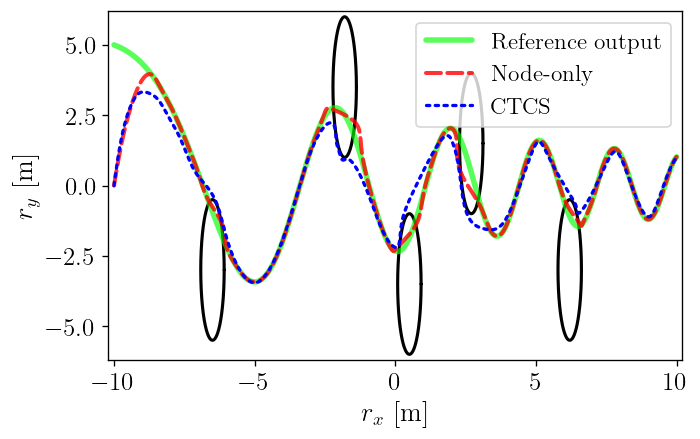

In [17]:
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

fig, (ax0) = plt.subplots(figsize=(6, 6), nrows=1, sharex=True)

H_obs = params['H_obs']
p_obs = params['p_obs']
r_obs = params['r_obs']
for j, _ in enumerate(H_obs):
    xo, yo = p_obs[j]
    eigval, eigvec = np.linalg.eigh(H_obs[j])
    theta = np.linspace(0, 2*np.pi, 1000)
    ellipsis = (r_obs/eigval[None, :] * eigvec) @ [np.sin(theta), np.cos(theta)]
    ax0.plot(xo + ellipsis[0, :], yo + ellipsis[1, :], color='black', lw=3/2*1.*1.25)

afs = 1.1
ref_pos_data = params['ref_pos'](np.linspace(0, params['total_time'], results_3['times'].shape[0]))
ax0.plot(ref_pos_data.T[:, 0], 
            ref_pos_data.T[:, 1], 
            color='lime', lw=afs*3.0, zorder=8, alpha=0.65, label='Reference output')

ax0.plot(results_4['x_all'][:, 0], 
            results_4['x_all'][:, 1], 
            color='red', lw=afs*2.2, alpha=0.8, linestyle='dashed', 
            zorder=8, label="Node-only")

ax0.plot(results_3['x_all'][:, 0], 
            results_3['x_all'][:, 1], 
            color='blue', lw=afs*1.8, linestyle='dotted', 
            zorder=8, label="CTCS")

ax0.set_xlim(-10.2, 10.2)
ax0.set_ylim(-6.2, 6.2)

ax0.legend(loc="upper right", fontsize=14)
ax0.set_xlabel('$r_x$ $\mathrm{[m]}$', size=16)
ax0.set_ylabel('$r_y$ $\mathrm{[m]}$', size=16)
ax0.set_aspect('equal')

if save_fig: fig.savefig(path_1 + '/' + fldr + '/Num_sim.' + fig_format, bbox_inches="tight")


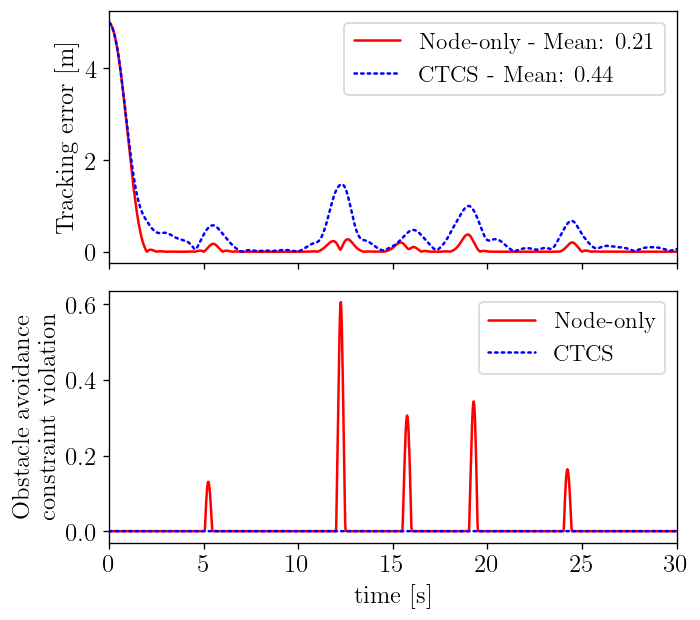

In [18]:
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

fig, (ax0, ax1) = plt.subplots(figsize=(6, 16/3), nrows=2, sharex=True)

ref_pos_data = params['ref_pos'](np.linspace(0, params['total_time'], results_3['times'].shape[0]))
tracking_err = np.linalg.norm(results_3['x_all'][:, 0:2] - ref_pos_data.T, axis=1)
tracking_err_node = np.linalg.norm(results_4['x_all'][:, 0:2] - ref_pos_data.T, axis=1)

tracking_err_mean = tracking_err.mean()
tracking_err_node_mean = tracking_err_node.mean()

ax0.plot(results_4['times'], tracking_err_node, c='red', label="Node-only - Mean: "+str(tracking_err_node_mean.round(2)))
ax0.plot(results_3['times'], tracking_err, c='blue', linestyle='dotted', label="CTCS - Mean: "+str(tracking_err_mean.round(2)))

obs_cost_3 = 0
obs_cost_4 = 0
for idx in range(len(p_obs)):
    obs_cost_3 += np.maximum(0, 1. - np.linalg.norm(H_obs[idx] @ (results_3['x_all'][:, 0:2] - p_obs[idx]).T, axis=0))
    obs_cost_4 += np.maximum(0, 1. - np.linalg.norm(H_obs[idx] @ (results_4['x_all'][:, 0:2] - p_obs[idx]).T, axis=0))

ax1.plot(results_4['times'], obs_cost_4, c='red', label="Node-only") #+str(obs_cost_4.sum().round(2))
ax1.plot(results_3['times'], obs_cost_3, c='blue', linestyle='dotted', label="CTCS") #+str(obs_cost_3.sum().round(2))

ax1.set_ylabel('Obstacle avoidance \n constraint violation', size=15)
ax0.set_ylabel('Tracking error [m]', size=15)
ax1.set_xlabel('time [s]', size=15)
ax0.legend(loc="upper right", fontsize=14)
ax1.legend(loc="upper right", fontsize=14)

if save_fig: fig.savefig(path_1 + '/' + fldr + '/cost_cons_time.' + fig_format, bbox_inches="tight")

In [19]:
params0 = params_fcn()
params = augmented_dynamics(params0)
params['ite'] = 10
results_10 = RUN(params)

100%|██████████| 1200/1200 [00:11<00:00, 100.50it/s]


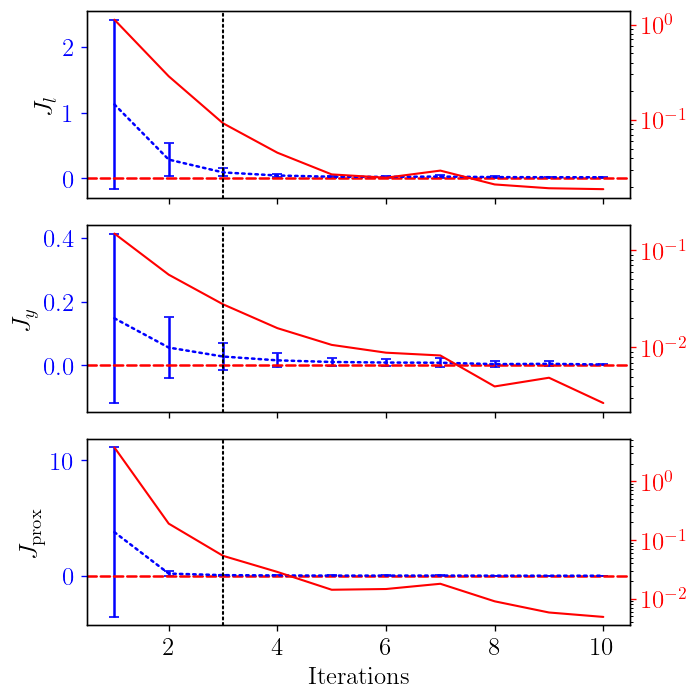

In [20]:
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

fig, (ax3, ax1, ax2) = plt.subplots(figsize=(6, 6), nrows=3, sharex=True)

x = np.arange(1, params['ite']+1, 1.0)

tracking_slack_sum = results_10['tracking_slack_list_all'].sum(axis=0)
tracking_slack_mean = results_10['tracking_slack_list_all'].mean(axis=0)
tracking_slack_std = results_10['tracking_slack_list_all'].std(axis=0)
ax3.errorbar(x, tracking_slack_mean, yerr=tracking_slack_std, fmt=':', c='blue', label='linear scale', capsize=3, capthick=1)

# ax3.set_yscale('log')
ax3.set_xlim(0.5, params['ite']+0.5)
ax3.axhline(y = 0., color = 'r', linestyle = '--') 
ax3.tick_params(axis='y', colors='blue')

ax32 = ax3.twinx() 
ax32.plot(x, tracking_slack_mean, c='red', label='log scale', lw=1.25)
ax32.set_yscale('log')
ax32.set_xlim(0.5, 10.5)
ax32.axvline(x=3, color='black', ls=':', lw=1.25)
ax32.tick_params(axis='y', colors='red')

obs_mean = results_10['obstacle_cost_list_all'].mean(axis=0)
obs_std = results_10['obstacle_cost_list_all'].std(axis=0)
ax1.errorbar(x, obs_mean, yerr=obs_std, fmt=':', c='blue', label='linear scale', capsize=3, capthick=1)
ax1.axhline(y = 0., color = 'r', linestyle = '--') 
ax1.tick_params(axis='y', colors='blue')

ax12 = ax1.twinx() 
ax12.plot(x, obs_mean, c='red', label='log scale', lw=1.25)
ax12.set_yscale('log')
ax12.set_xlim(0.5, params['ite']+0.5)
ax12.axvline(x=3, color='black', ls=':', lw=1.25)
ax12.tick_params(axis='y', colors='red')

tr_mean = results_10['ptr_cost_list_all'].mean(axis=0)
tr_std = results_10['ptr_cost_list_all'].std(axis=0)
ax2.errorbar(x, tr_mean, yerr=tr_std, fmt=':', c='blue', label='linear scale', capsize=3, capthick=1)
ax2.axhline(y = 0., color = 'r', linestyle = '--') 
ax2.tick_params(axis='y', colors='blue')

ax22 = ax2.twinx() 
ax22.plot(x, tr_mean, c='red', label='log scale', lw=1.25)
ax22.set_yscale('log')
ax22.set_xlim(0.5, params['ite']+0.5)
ax22.axvline(x=3, color='black', ls=':', lw=1.25)
ax22.tick_params(axis='y', colors='red')

ax3.set_ylabel('$J_l$', size=16)
ax1.set_ylabel('$J_y$', size=16)
ax2.set_ylabel('$J_{\mathrm{prox}}$', size=16)
ax2.set_xlabel('Iterations', size=15)

if save_fig: fig.savefig(path_1 + '/' + fldr + '/error_bars.pdf', bbox_inches="tight")

In [21]:
def generate_images(results, params, path_1, fldr, type_):
    N_data = results['times'].shape[0]
    del_data = 12
    for ijk in range(0, N_data, del_data):
        
        time = results['times'][ijk]
        print('time: ', time)
        
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot()

        H_obs = params['H_obs']
        p_obs = params['p_obs']
        r_obs = params['r_obs']
        for j, _ in enumerate(H_obs):
            xo, yo = p_obs[j]
            eigval, eigvec = np.linalg.eigh(H_obs[j])
            theta = np.linspace(0, 2*np.pi, 1000)
            ellipsis = (r_obs/eigval[None, :] * eigvec) @ [np.sin(theta), np.cos(theta)]
            ax.plot(xo + ellipsis[0, :], yo + ellipsis[1, :], color='black', lw=3/2*1.*1.25)

        afs = 1.1
        ref_pos_data = params['ref_pos'](np.linspace(0, params['total_time'], results['times'].shape[0]))
        ax.plot(ref_pos_data.T[:, 0], ref_pos_data.T[:, 1], 
                color='lime', lw=afs*3.0, zorder=8, alpha=0.65, label='Reference output')

        if type_=='ctcs':
                ax.plot(results['x_all'][:ijk, 0], 
                        results['x_all'][:ijk, 1], 
                        color='blue', lw=afs*1.8, linestyle='dotted', 
                        zorder=8, label="CTCS")

                ax.plot(results['x_all'][ijk, 0], 
                        results['x_all'][ijk, 1], 
                        alpha = 1, c='blue', marker='X', 
                        markersize=15, zorder=10)

        elif type_=='node':
                ax.plot(results['x_all'][:ijk, 0], 
                        results['x_all'][:ijk, 1], 
                        color='red', lw=afs*2.2, linestyle='dashed', 
                        zorder=8, label="Node-only")

                ax.plot(results['x_all'][ijk, 0], 
                        results['x_all'][ijk, 1], 
                        alpha = 1, c='red', marker='X', 
                        markersize=15, zorder=10)

        ax.plot(ref_pos_data.T[ijk, 0], ref_pos_data.T[ijk, 1], 
                alpha = 1, c='lime', marker='X', 
                markersize=10, zorder=10)

        k_mpc = min(int(time // params['t_mpc']), results['x_nmpc_all'].shape[-1]-1)
        ax.scatter(results['x_nmpc_all'][0, :, k_mpc], 
                   results['x_nmpc_all'][1, :, k_mpc], 
                   c='black', s=10, label="SCP Result")
        
        
        ax.set_xlim(-10.2, 10.2)
        ax.set_ylim(-6.2, 6.2)

        ax.legend(loc="upper right", fontsize=14)
        ax.set_xlabel('$r_x$ $\mathrm{[m]}$', size=16)
        ax.set_ylabel('$r_y$ $\mathrm{[m]}$', size=16)
        ax.set_aspect('equal')

        zz = str(ijk).zfill(4)
        fig.savefig(path_1 + '/' + fldr + '/' + zz + '_' + type_, bbox_inches="tight", dpi=300)

        plt.close(fig)

def make_gif(frame_folder, type_):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"+type_+".png"))][::2]
    frame_one = frames[0]
    frame_one.save(frame_folder+"/"+ type_ + "_animation.gif", format="GIF", 
                   append_images=frames, save_all=True, duration=0.1, loop=0)

In [22]:
list_anim = ['node', 'ctcs']
if save_animation:
        for type_ in list_anim:
                if type_ == 'node': results = results_4
                elif type_ == 'ctcs': results = results_3
                generate_images(results, params, path_1, fldr, type_)
                make_gif(fldr, type_)

<img src="sim/node_animation.gif" width="750" align="center">

<img src="sim/ctcs_animation.gif" width="750" align="center">